In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
from sklearn.datasets import fetch_lfw_people

# Fetch people with at least 2 images
lfw_people = fetch_lfw_people(min_faces_per_person=2, resize=1.0, download_if_missing=True)

print("Shape:", lfw_people.images.shape)  # (n_samples, height, width)
print("Number of people:", len(lfw_people.target_names))
print("Total images:", len(lfw_people.images))


Shape: (9164, 125, 94)
Number of people: 1680
Total images: 9164


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

# Get images and labels
X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names

# Find unique persons
unique_ids = np.unique(y)

# Split persons into train and test (no overlap of people!)
train_ids, test_ids = train_test_split(unique_ids, test_size=0.3, random_state=42)

# Create train and test sets
X_train = X[np.isin(y, train_ids)]
y_train = y[np.isin(y, train_ids)]

X_test = X[np.isin(y, test_ids)]
y_test = y[np.isin(y, test_ids)]


In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6617, 125, 94)
(6617,)
(2547, 125, 94)
(2547,)


In [5]:
pairs = []
labels = []

# For each person
for person_id in np.unique(y_train):
    # Get all images of that person
    person_images = X_train[y_train == person_id]

    # Create positive pairs (same person)
    for i in range(len(person_images)):
        for j in range(i+1, len(person_images)):
            pairs.append([person_images[i], person_images[j]])
            labels.append(1)

    # Create negative pairs (different people)
    number_of_negatives_per_person = 3
    for _ in range(number_of_negatives_per_person):
        other_person_id = np.random.choice(np.setdiff1d(np.unique(y_train), [person_id]))
        other_person_image = X_train[y_train == other_person_id][0]

        pairs.append([person_images[0], other_person_image])
        labels.append(0)


In [6]:
test_pairs = []
test_labels_pairs = []

for person_id in np.unique(y_test):
    person_images = X_test[y_test == person_id]

    # Positive pairs
    for i in range(len(person_images)):
        for j in range(i + 1, len(person_images)):
            test_pairs.append([person_images[i], person_images[j]])
            test_labels_pairs.append(1)

    # Negative pairs
    number_of_negatives_per_person = 3
    for _ in range(number_of_negatives_per_person):
        other_person_id = np.random.choice(np.setdiff1d(np.unique(y_test), [person_id]))
        other_person_image = X_test[y_test == other_person_id][0]

        test_pairs.append([person_images[0], other_person_image])
        test_labels_pairs.append(0)

test_pairs = np.array(test_pairs)
test_labels_pairs = np.array(test_labels_pairs)


In [7]:
import numpy as np

# Analyze Train Set
unique_train_labels, train_counts = np.unique(y_train, return_counts=True)
print(f"Train set - Number of people: {len(unique_train_labels)}")
print(f"Train set - Total images: {len(y_train)}")
print(f"Train set - Average images per person: {train_counts.mean():.2f}")
print(f"Train set - Min images per person: {train_counts.min()}")
print(f"Train set - Max images per person: {train_counts.max()}")

# Analyze Test Set
unique_test_labels, test_counts = np.unique(y_test, return_counts=True)
print(f"\nTest set - Number of people: {len(unique_test_labels)}")
print(f"Test set - Total images: {len(y_test)}")
print(f"Test set - Average images per person: {test_counts.mean():.2f}")
print(f"Test set - Min images per person: {test_counts.min()}")
print(f"Test set - Max images per person: {test_counts.max()}")


Train set - Number of people: 1176
Train set - Total images: 6617
Train set - Average images per person: 5.63
Train set - Min images per person: 2
Train set - Max images per person: 530

Test set - Number of people: 504
Test set - Total images: 2547
Test set - Average images per person: 5.05
Test set - Min images per person: 2
Test set - Max images per person: 236


In [8]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((105, 105))
])


In [9]:
from torch.utils.data import Dataset

class SiameseDataset(Dataset):
    def __init__(self, images, labels, transform=transform):
        self.images = images
        self.labels = labels
        self.transform = transform

        # Group images by person
        self.person_to_images = {}
        for idx, label in enumerate(labels):
            if label not in self.person_to_images:
                self.person_to_images[label] = []
            self.person_to_images[label].append(idx)

        self.person_ids = list(self.person_to_images.keys())

    def __getitem__(self, idx):
      should_get_same_class = torch.rand(1).item() < 0.5

      img1_idx = torch.randint(len(self.images), (1,)).item()
      img1 = self.images[img1_idx]
      label1 = self.labels[img1_idx]

      if should_get_same_class:
          img2_idx = np.random.choice(self.person_to_images[label1])
          label = 1
      else:
          different_label = label1
          while different_label == label1:
              different_label = np.random.choice(self.person_ids)
          img2_idx = np.random.choice(self.person_to_images[different_label])
          label = 0

      img2 = self.images[img2_idx]

      if self.transform:
          img1 = self.transform(img1)
          img2 = self.transform(img2)

      return img1, img2, torch.tensor(label, dtype=torch.float32)


    def __len__(self):
        return len(self.images)


In [10]:
from torch.utils.data import DataLoader

# Assuming your images/labels are numpy arrays
train_dataset = SiameseDataset(X_train, y_train)

train_loader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=32,  # how many pairs per batch
    num_workers=2
)


In [11]:
import torch.nn as nn

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10),  # (1, 105, 105) -> (64, 96, 96)
            nn.ReLU(),
            nn.MaxPool2d(2),                   # -> (64, 48, 48)

            nn.Conv2d(64, 128, kernel_size=7),  # -> (128, 42, 42)
            nn.ReLU(),
            nn.MaxPool2d(2),                    # -> (128, 21, 21)

            nn.Conv2d(128, 128, kernel_size=4), # -> (128, 18, 18)
            nn.ReLU(),
            nn.MaxPool2d(2),                    # -> (128, 9, 9)

            nn.Conv2d(128, 256, kernel_size=4), # -> (256, 6, 6)
            nn.ReLU()
        )

        self.fc1 = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.Sigmoid()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        l1_distance = torch.abs(output1 - output2)
        out = self.fc2(l1_distance)
        return out


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Model, Loss, Optimizer
model = SiameseNetwork().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
losses_per_epoch = []
test_accuracies_per_epoch = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (img1, img2, label) in enumerate(train_loader):
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        optimizer.zero_grad()

        # Forward pass
        output = model(img1, img2).squeeze()  # squeeze to match shape

        # Loss
        loss = criterion(output, label)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses_per_epoch.append(epoch_loss)

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0

    for pair, label in zip(test_pairs, test_labels_pairs):
        img1 = transform(pair[0]).unsqueeze(0).to(device)
        img2 = transform(pair[1]).unsqueeze(0).to(device)
        label = torch.tensor(label, dtype=torch.float32).to(device)

        with torch.no_grad():
            output = model(img1, img2).squeeze()

        predicted = torch.sigmoid(output).item()
        predicted_label = 1 if predicted >= 0.5 else 0

        if predicted_label == label.item():
            correct += 1
        total += 1

    epoch_test_accuracy = correct / total
    test_accuracies_per_epoch.append(epoch_test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f} | Test Accuracy: {epoch_test_accuracy*100:.2f}%")


Epoch [1/20] | Loss: 0.6746 | Test Accuracy: 96.50%
Epoch [2/20] | Loss: 0.6694 | Test Accuracy: 96.50%
Epoch [3/20] | Loss: 0.6704 | Test Accuracy: 96.50%
Epoch [4/20] | Loss: 0.6708 | Test Accuracy: 96.50%
Epoch [5/20] | Loss: 0.6703 | Test Accuracy: 96.50%
Epoch [6/20] | Loss: 0.6692 | Test Accuracy: 96.50%
Epoch [7/20] | Loss: 0.6754 | Test Accuracy: 96.50%
Epoch [8/20] | Loss: 0.6674 | Test Accuracy: 96.50%
Epoch [9/20] | Loss: 0.6668 | Test Accuracy: 96.50%
Epoch [10/20] | Loss: 0.6743 | Test Accuracy: 96.50%
Epoch [11/20] | Loss: 0.6716 | Test Accuracy: 96.50%
Epoch [12/20] | Loss: 0.6677 | Test Accuracy: 96.50%
Epoch [13/20] | Loss: 0.6681 | Test Accuracy: 96.50%
Epoch [14/20] | Loss: 0.6669 | Test Accuracy: 96.50%
Epoch [15/20] | Loss: 0.6649 | Test Accuracy: 96.50%
Epoch [16/20] | Loss: 0.6634 | Test Accuracy: 96.50%
Epoch [17/20] | Loss: 0.6643 | Test Accuracy: 96.50%
Epoch [18/20] | Loss: 0.6665 | Test Accuracy: 96.50%
Epoch [19/20] | Loss: 0.6636 | Test Accuracy: 96.50%
Ep

In [13]:
model.eval()

correct = 0
total = 0

for pair, label in zip(test_pairs, test_labels_pairs):
    img1 = transform(pair[0]).unsqueeze(0).to(device)
    img2 = transform(pair[1]).unsqueeze(0).to(device)
    label = torch.tensor(label, dtype=torch.float32).to(device)

    with torch.no_grad():
        output = model(img1, img2).squeeze()

    predicted = torch.sigmoid(output).item()
    predicted_label = 1 if predicted >= 0.5 else 0

    if predicted_label == label.item():
        correct += 1
    total += 1

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


Test Accuracy: 96.50%


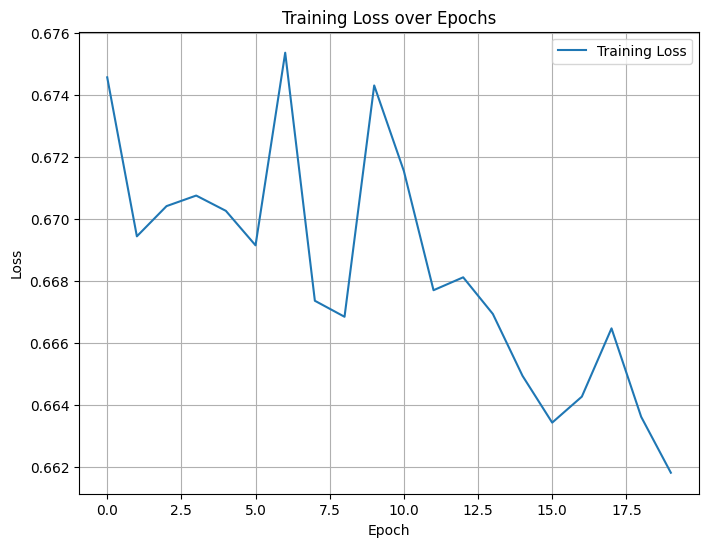

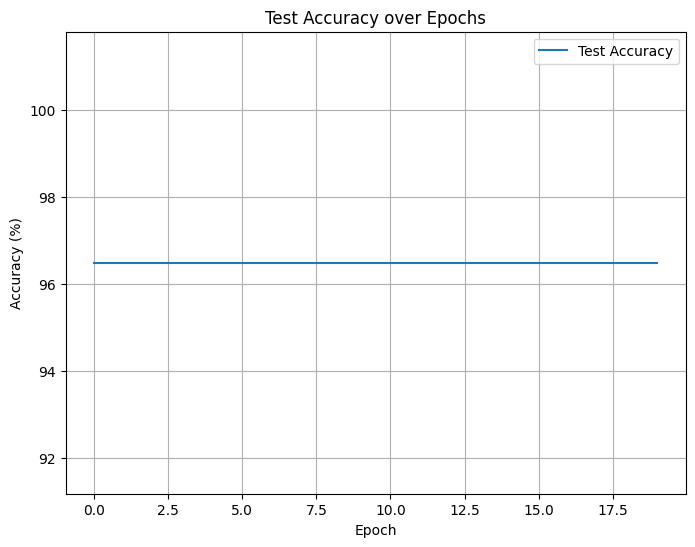

In [14]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(8,6))
plt.plot(losses_per_epoch, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(8,6))
plt.plot([acc * 100 for acc in test_accuracies_per_epoch], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()



Total correct predictions: 41628
Total incorrect predictions: 1512


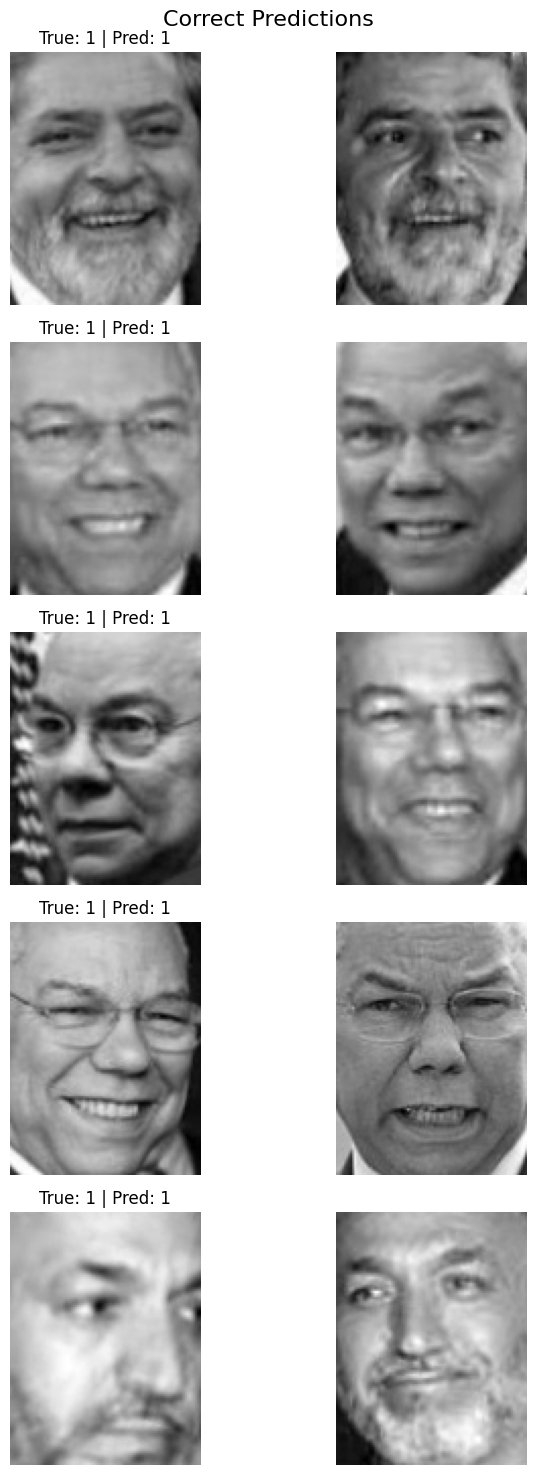

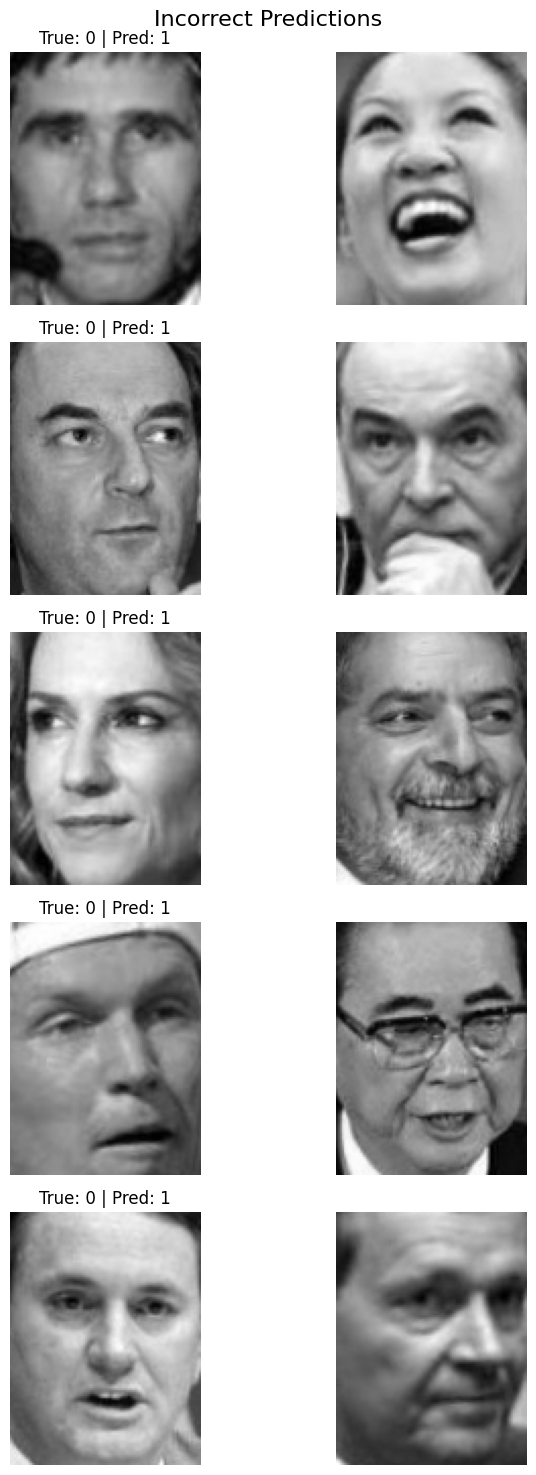

In [16]:
import random
import matplotlib.pyplot as plt

# Function to display multiple image pairs in a grid
def show_multiple_pairs(pairs, title, num_examples=5):
    n = min(num_examples, len(pairs))
    fig, axes = plt.subplots(n, 2, figsize=(8, 3 * n))

    for i in range(n):
        img1, img2, true_label, predicted_label = pairs[i]

        axes[i, 0].imshow(img1, cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"True: {int(true_label)} | Pred: {int(predicted_label)}")

        axes[i, 1].imshow(img2, cmap='gray')
        axes[i, 1].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Lists to store correct and incorrect predictions
correct_predictions = []
incorrect_predictions = []

# Set model to evaluation mode
model.eval()

# Iterate over all test pairs
for pair, label in zip(test_pairs, test_labels_pairs):
    img1_tensor = transform(pair[0]).unsqueeze(0).to(device)
    img2_tensor = transform(pair[1]).unsqueeze(0).to(device)
    label_tensor = torch.tensor(label, dtype=torch.float32).to(device)

    with torch.no_grad():
        output = model(img1_tensor, img2_tensor).squeeze()

    predicted_prob = torch.sigmoid(output).item()
    predicted_label = 1 if predicted_prob >= 0.5 else 0

    if predicted_label == label:
        correct_predictions.append((pair[0], pair[1], label, predicted_label))
    else:
        incorrect_predictions.append((pair[0], pair[1], label, predicted_label))

# Shuffle to select random examples
random.shuffle(correct_predictions)
random.shuffle(incorrect_predictions)

# --- Displaying multiple examples ---

print(f"Total correct predictions: {len(correct_predictions)}")
print(f"Total incorrect predictions: {len(incorrect_predictions)}")

# Show correct examples
if len(correct_predictions) > 0:
    show_multiple_pairs(correct_predictions, title="Correct Predictions", num_examples=5)

# Show incorrect examples
if len(incorrect_predictions) > 0:
    show_multiple_pairs(incorrect_predictions, title="Incorrect Predictions", num_examples=5)
